In [1]:
# import segmentation_models as sm
import os
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from skimage import io, color, exposure
from skimage.transform import rescale
from skimage.filters import unsharp_mask, sato
from skimage.filters import frangi
from skimage import io, filters, exposure
from PIL import Image

In [2]:
# train_image = "./train-images/01_dr.JPG"

In [3]:
import glob

train_images = []

path = './train-images/'

for i in range(1, 11):
    filename_pattern = f"{path}{i:02d}_dr.JPG"
    
    file_list = glob.glob(filename_pattern)
    train_images.append(file_list[0])

In [4]:
def load_image(path):
    image = io.imread(path)    
    return image

In [5]:
def process_image(train_image):
    original_image = load_image(train_image)
    kernel = np.ones((5, 5), np.uint8)

    image_green_channel = original_image[:, :, 1]
    thresh = cv2.dilate(image_green_channel, kernel, iterations=1)
    denoised_image = cv2.fastNlMeansDenoising(thresh, None, 10, 5, 21)
    sharp_image = exposure.equalize_hist(denoised_image)
    frangi_image = frangi(sharp_image, scale_step=2) 

    for i in range(len(frangi_image)):
        for j in range(len(frangi_image[i])):
            if frangi_image[i][j] > 0.0001:
                frangi_image[i][j] = 255
            else:
                frangi_image[i][j] = 0

    threshold_value = 100
    ret, thresh = cv2.threshold(frangi_image, threshold_value, 255, cv2.THRESH_BINARY)
    blackAndWhiteImage = cv2.erode(thresh, kernel)
    return frangi_image * blackAndWhiteImage

In [7]:
trained_images = []

for train_image in train_images:
    trained_images.append(process_image(train_image))

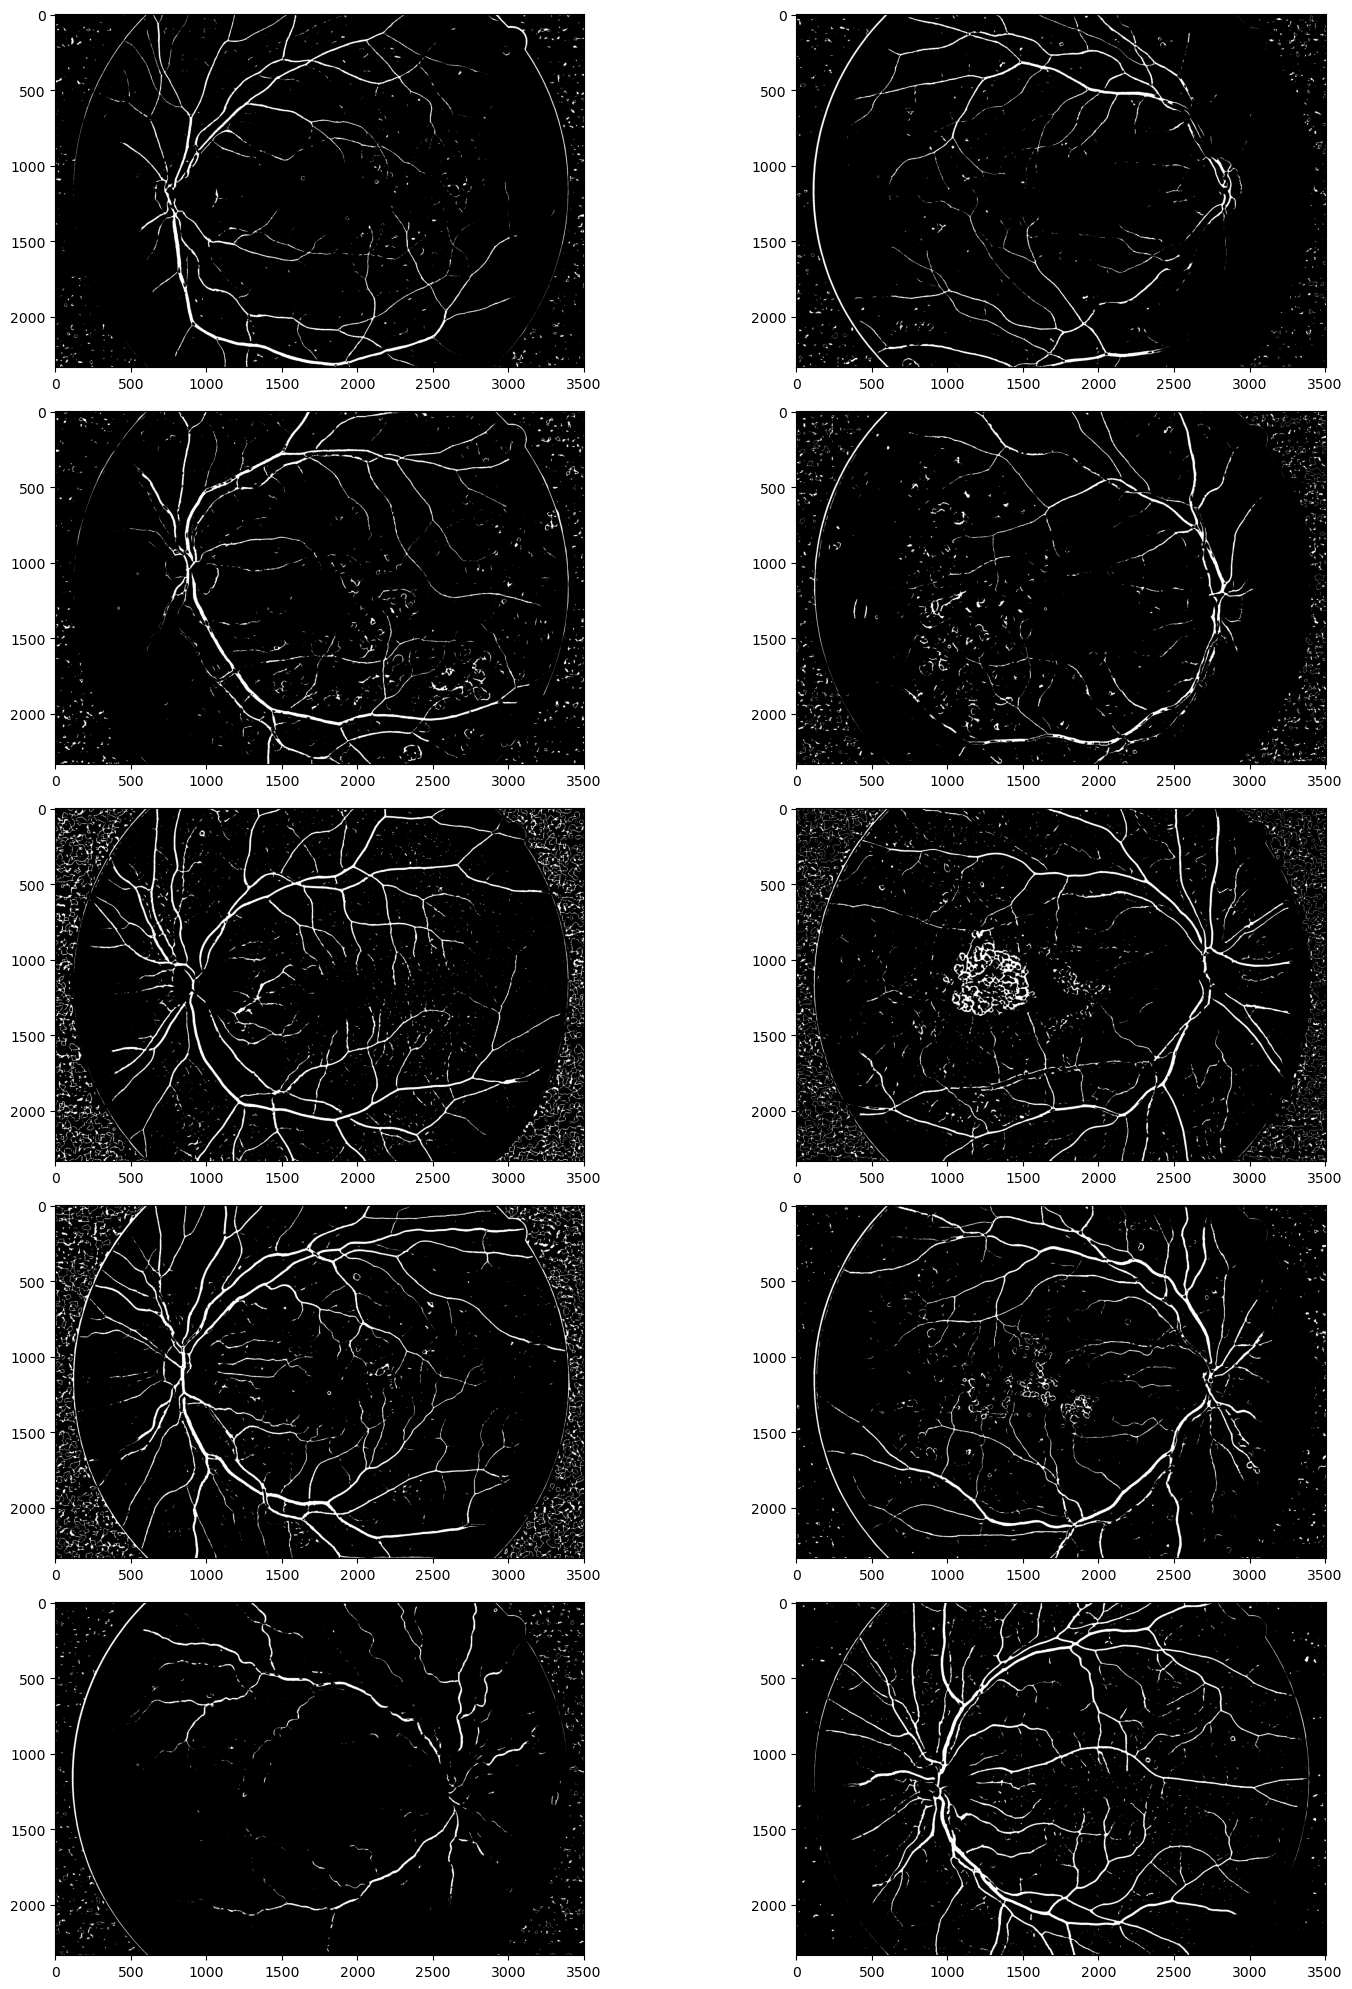

In [19]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))

for idx, train_image in enumerate(train_images):
    row_idx = idx // 2
    col_idx = idx % 2
    axes[row_idx, col_idx].imshow(trained_images[idx], cmap='gray')
    
plt.tight_layout()
plt.show()


In [7]:
preprocessed_image = frangi_image * blackAndWhiteImage

img = cv2.imread('./fov-mask/01_h_mask.tif', cv2.IMREAD_GRAYSCALE)

h1, w1 = len(preprocessed_image), len(preprocessed_image[0])
h2, w2 = img.shape

if h1 * w1 > h2 * w2:
    preprocessed_image = cv2.resize(preprocessed_image, (w2, h2))
else:
    img = cv2.resize(img, (w1, h1))

preprocessed_image = preprocessed_image / 255


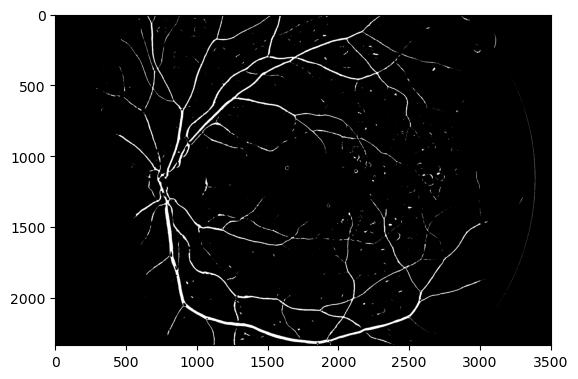

In [8]:
detected_vessels_image = []

for i, j in enumerate(preprocessed_image):
    res1 = []
    for x, y in enumerate(j):
        if img[i][x]  < 100:
            res1.append(0)
        else:
            res1.append(preprocessed_image[i][x])

    detected_vessels_image.append(res1)


plt.imshow(detected_vessels_image,  cmap='gray')
plt.show()

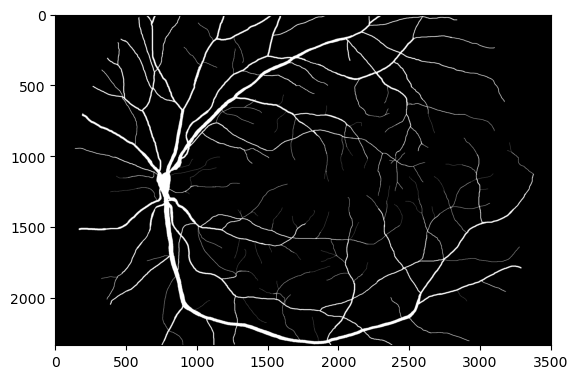

In [9]:
manually_labeled_image = cv2.imread('./manually_labeled_images/01_dr.tif', cv2.IMREAD_GRAYSCALE)
plt.imshow(manually_labeled_image,  cmap='gray')
plt.show()

In [10]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix_values(image):
    confusion_mat = confusion_matrix(image.flatten(), np.array(detected_vessels_image).flatten())
    true_negative, false_positive, false_negative, true_positive = confusion_mat.ravel()
    accuracy = (true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)

    print(confusion_mat)


In [11]:
print(np.array(detected_vessels_image, dtype=np.float32))
detected_vessels_image = np.array(detected_vessels_image, dtype=np.float32)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
# mat = original_image

def get_segments(image):
    parts_num = 5
    num_rows = image.shape[0] // parts_num
    num_cols = image.shape[1] // parts_num
    segments = []

    for i in range(0, num_rows, parts_num):
        for j in range(0, num_cols, parts_num):
            mat_5x5 = image[i: i + parts_num, j: j + parts_num]
            segments.append(mat_5x5)
    
    return segments


In [13]:
# manually_labeled_image_segments = get_segments(manually_labeled_image)
detected_vessels_image_segments = get_segments(detected_vessels_image)
image_segments = get_segments(original_image)

In [14]:
def get_image_statistics(segments):
    segment_stats = np.array([])
    
    for segment in segments:
        channels = np.array(segment, dtype=np.float32).reshape(-1, 3)
        color_variation = np.var(channels, axis=0)
        gray_segment = cv2.cvtColor(segment, cv2.COLOR_BGR2GRAY)
        central_moment = cv2.moments(gray_segment)
        hu_moment = cv2.HuMoments(central_moment)[:,0]
        
        segment_stats = np.hstack((segment_stats, np.hstack([color_variation, central_moment, hu_moment])))

    return segment_stats

In [15]:
# image_stats = get_image_statistics(image_segments)

In [16]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier()
# rf.fit(manually_labeled_image_stats, detected_vessels_image_stats)

In [17]:
X, y = train[features], train[labels]

sampler = RandomUnderSampler(sampling_strategy=1, random_state=seed)
X, y = sampler.fit_resample(X, y)

NameError: name 'train' is not defined